In [1]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
df = pd.read_csv("../outputs/data_clean.csv")
df.set_index(pd.to_datetime(df.iloc[:, 0], format="%Y-%m-%d"), inplace=True)
names = df["name"].unique()
types = df["type"].unique()
df = df.drop(df.columns[0], axis=1)

In [4]:
cite = pd.read_csv("../data/citations_for_site_data_Ameriflux.csv", skiprows=5)
cite.rename(columns={"site_id": "name"}, inplace=True)

# Initialize an empty DataFrame to store the results
data_cite = []

for name in names:
    site_name = name
    site_type = df[df["name"] == name]["type"].values[0]
    t1 = df[df["name"] == name].index[0]
    t2 = df[df["name"] == name].index[-1]
    date_range = str(t1.date()) + " - " + str(t2.date())
    site_cite = cite[cite["name"] == name]

    if len(site_cite) == 0:
        doi_url = "FLUXNET2015"
        data_cite.append(
            {
                "Name": site_name,
                "Type": site_type,
                "Date Range": date_range,
                "URL": doi_url,
            }
        )
        continue
    doi_url = site_cite["doi_url"].values[0]
    data_cite.append(
        {
            "Name": site_name,
            "Type": site_type,
            "Date Range": date_range,
            "URL": doi_url,
        }
    )
data_cite = pd.DataFrame(data_cite)
data_cite.to_csv("../outputs/data_cite.csv", index=False)

In [5]:
results = []
for type in types:
    df_type = df[df["type"] == type]
    number_of_sites = len(df_type["name"].unique())
    number_of_obs = len(df_type)
    results.append(
        {
            "Type": type,
            "Number of Sites": number_of_sites,
            "Number of Observations": number_of_obs,
        }
    )
results = pd.DataFrame(results)
results.to_csv("../outputs/data_summary.csv", index=False)

In [6]:
site_annual_max_lue = []
site_annual_max_lue_se = []
site_top_n = []
site_max_lue = []

for name in names:
    site_df = df[df["name"] == name]
    type = site_df["type"].iloc[0]
    site_df = site_df[["fpar", "nirv", "nirvp", "fesc", "lue"]]

    # Calculate the annual maximum LUE
    annual_max_lue_index = site_df.groupby(site_df.index.year)["lue"].idxmax()
    annual_max = site_df.loc[annual_max_lue_index]
    annual_max_mean = annual_max.median()
    annual_max_mean.loc["type"] = type
    annual_max_mean.loc["name"] = name

    annual_max_std = annual_max.std()
    n = len(annual_max)
    annual_max_se = annual_max_std / np.sqrt(n)
    annual_max_se.loc["type"] = type
    annual_max_se.loc["name"] = name

    site_annual_max_lue.append(annual_max_mean)
    site_annual_max_lue_se.append(annual_max_se)

site_annual_max_lue = pd.DataFrame(site_annual_max_lue)
site_annual_max_lue_se = pd.DataFrame(site_annual_max_lue_se)

In [7]:
site_annual_max_lue = site_annual_max_lue[site_annual_max_lue["fesc"] <= 1]
site_annual_max_lue_se = site_annual_max_lue_se[
    site_annual_max_lue_se.index.isin(site_annual_max_lue.index)
]

In [8]:
site_annual_max_lue_grouped_mean = (
    site_annual_max_lue[["fpar", "nirv", "nirvp", "fesc", "lue", "type"]]
    .groupby("type")
    .mean()
)
site_annual_max_lue_grouped_std = (
    site_annual_max_lue[["fpar", "nirv", "nirvp", "fesc", "lue", "type"]]
    .groupby("type")
    .std()
)
n = site_annual_max_lue.groupby("type").size()
site_annual_max_lue_grouped_se = site_annual_max_lue_grouped_std.div(np.sqrt(n), axis=0)

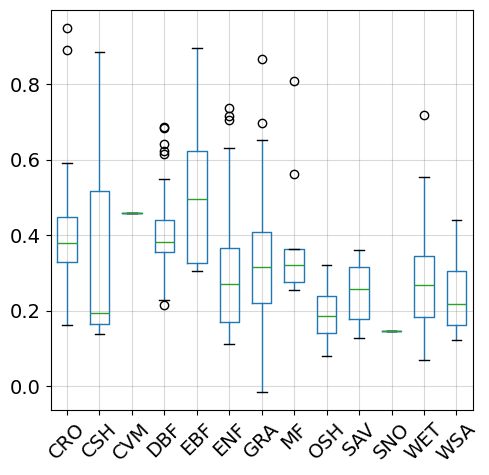

In [9]:
fig, ax = plt.subplots(figsize=(5, 5))

# Create the boxplots
site_annual_max_lue.boxplot(column="fesc", by="type", widths=0.6, ax=ax)
plt.title("")
plt.xlabel("")
plt.ylabel("")
plt.tick_params(axis="x", labelsize=14, labelrotation=45)
plt.tick_params(axis="y", labelsize=14)
ax.grid(color="gray", linestyle="-", alpha=0.3)
ax.xaxis.label.set_weight("bold")
fig.suptitle("")

# for tick in ax.get_xticklabels():
#     tick.set_fontweight('bold')
# for tick in ax.get_yticklabels():
#     tick.set_fontweight('bold')

plt.tight_layout()
plt.savefig("../outputs/figures/annual_max_fesc_box.png")

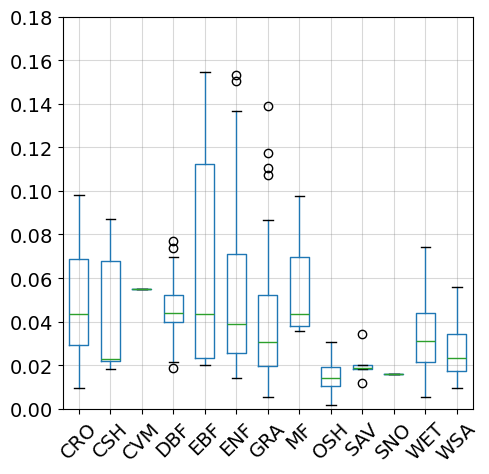

In [10]:
fig, ax = plt.subplots(figsize=(5, 5))

# Create the boxplots
site_annual_max_lue.boxplot(column="lue", by="type", widths=0.6, ax=ax)
plt.title("")
plt.xlabel("")
plt.ylabel("")
plt.tick_params(axis="x", labelsize=14, labelrotation=45)
plt.tick_params(axis="y", labelsize=14)
plt.ylim(0, 0.18)
ax.grid(color="gray", linestyle="-", alpha=0.3)
fig.suptitle("")

# for tick in ax.get_xticklabels():
#     tick.set_fontweight('bold')
# for tick in ax.get_yticklabels():
#     tick.set_fontweight('bold')

plt.tight_layout()
plt.savefig("../outputs/figures/annual_max_lue_box.png")

  Variable     Slope  Intercept  R_squared
0     fesc  0.141907  -0.006863   0.856243
1     nirv  0.165727   0.015076   0.317794
2    nirvp  0.000425   0.025202   0.234938
3     fpar -0.029224   0.056234   0.080124


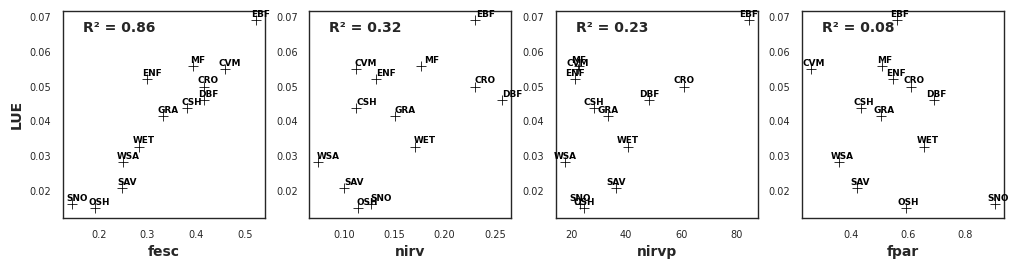

In [11]:
import pandas as pd
from sklearn.linear_model import LinearRegression

# Set a style and context for seaborn
sns.set(
    style="white", context="paper", font_scale=0.8
)  # Changed style to "white" to remove grids

# Create a 1x4 grid of subplots
fig, host = plt.subplots(1, 4, figsize=(10, 2.5))  # Adjusted figure size
host = host.flatten()

df_to_plot = site_annual_max_lue_grouped_mean
variables = ["fesc", "nirv", "nirvp", "fpar"]
y = "lue"

# Create an empty DataFrame to store results
results_df = pd.DataFrame(columns=["Variable", "Slope", "Intercept", "R_squared"])

for i, x in enumerate(variables):
    # Fit the model and calculate R²
    model = LinearRegression().fit(df_to_plot[[x]], df_to_plot[[y]])
    r2 = model.score(df_to_plot[[x]], df_to_plot[[y]])

    # Store slope, intercept, and R² in the DataFrame
    results_df.loc[i] = [x, model.coef_[0][0], model.intercept_[0], r2]

    # Create scatterplot
    scatter = sns.scatterplot(
        data=df_to_plot,
        x=x,
        y=y,
        marker="+",
        # hue="type",
        ax=host[i],
        color="black",
        legend=False,
        s=50,
    )

    # Add text to each point on the scatterplot
    for line in range(df_to_plot.shape[0]):
        scatter.text(
            df_to_plot[x].iloc[line] + 0.01,
            df_to_plot[y].iloc[line] + 0.001,
            df_to_plot.index[line],
            horizontalalignment="center",
            size="small",
            color="black",
            weight="semibold",
        )

    # Add R² to the plot
    host[i].text(
        0.1,
        0.9,
        f"R² = {r2:.2f}",
        transform=host[i].transAxes,
        fontsize=10,
        fontweight="bold",
    )  # Reduced font size

    # Set labels and title
    host[i].set_xlabel(x, fontsize=10, fontweight="bold")
    host[i].set_ylabel("")  # Removing y-label
    if i == 0:
        host[i].set_ylabel(
            "LUE", fontsize=10, fontweight="bold"
        )  # Added y-label to the first subplot

plt.tight_layout(pad=0.01)  # Adjust subplot parameters to give specified padding
plt.savefig("../outputs/figures/between_pft_scatter.png", dpi=300, bbox_inches="tight")

# Display the DataFrame with results
print(results_df)

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression

# Set a style and context for seaborn
sns.set(style="white", context="paper", font_scale=0.8)

# Load your data for site_annual_max_grouped_mean and site_annual_max_grouped_std
# Assuming these are already defined in your environment

df_to_plot = site_annual_max_lue_grouped_mean
variables = ["fesc", "nirv", "nirvp", "fpar"]
y = "lue"

for x in variables:
    # Create a single subplot with custom size
    fig, host = plt.subplots(1, 1, figsize=(3.5, 3.8))
    # Fit the model and calculate R²
    model = LinearRegression().fit(df_to_plot[[x]], df_to_plot[[y]])
    r2 = model.score(df_to_plot[[x]], df_to_plot[[y]])

    # Create scatterplot
    scatter = sns.scatterplot(
        data=df_to_plot,
        x=x,
        y=y,
        marker="+",
        # hue="type",
        ax=host,
        color="black",
        legend=False,
        s=50,
    )
    plt.errorbar(
        df_to_plot[x],
        df_to_plot[y],
        xerr=site_annual_max_lue_grouped_se[x],
        yerr=site_annual_max_lue_grouped_se[y],
        fmt="none",
        color="black",
        alpha=0.25,
    )

    # Add text to each point on the scatterplot
    for line in range(df_to_plot.shape[0]):
        scatter.text(
            df_to_plot[x].iloc[line] + 0.002,
            df_to_plot[y].iloc[line] + 0.0005,
            df_to_plot.index[line],
            horizontalalignment="center",
            size=12,
            color="black",
            # weight="semibold",
        )

    # Add R² to the plot
    host.text(
        0.1,
        0.9,
        f"R² = {r2:.2f}",
        transform=host.transAxes,
        fontsize=12,
        fontweight="bold",
    )

    # Set labels and title
    host.set_xlabel("")
    host.set_ylabel("")
    host.set_ylabel("")
    host.tick_params(axis="x", labelsize=12)
    host.tick_params(axis="y", labelsize=12)

    # Save the figure with x and y variables replaced in the filename
    plt.tight_layout(pad=0.01)
    plt.savefig(
        f"../outputs/figures/between_pft_{x}_{y}.png", dpi=300, bbox_inches="tight"
    )
    plt.clf()  # Clear the figure for the next iteration

# Close the figure
plt.close()

<Figure size 350x380 with 0 Axes>

<Figure size 350x380 with 0 Axes>

<Figure size 350x380 with 0 Axes>

<>:20: SyntaxWarning: invalid escape sequence '\m'
<>:20: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_1609287/3002029437.py:20: SyntaxWarning: invalid escape sequence '\m'
  axs[i].set_ylabel("LUE$_{\mathrm{Max}}$", fontsize=12)


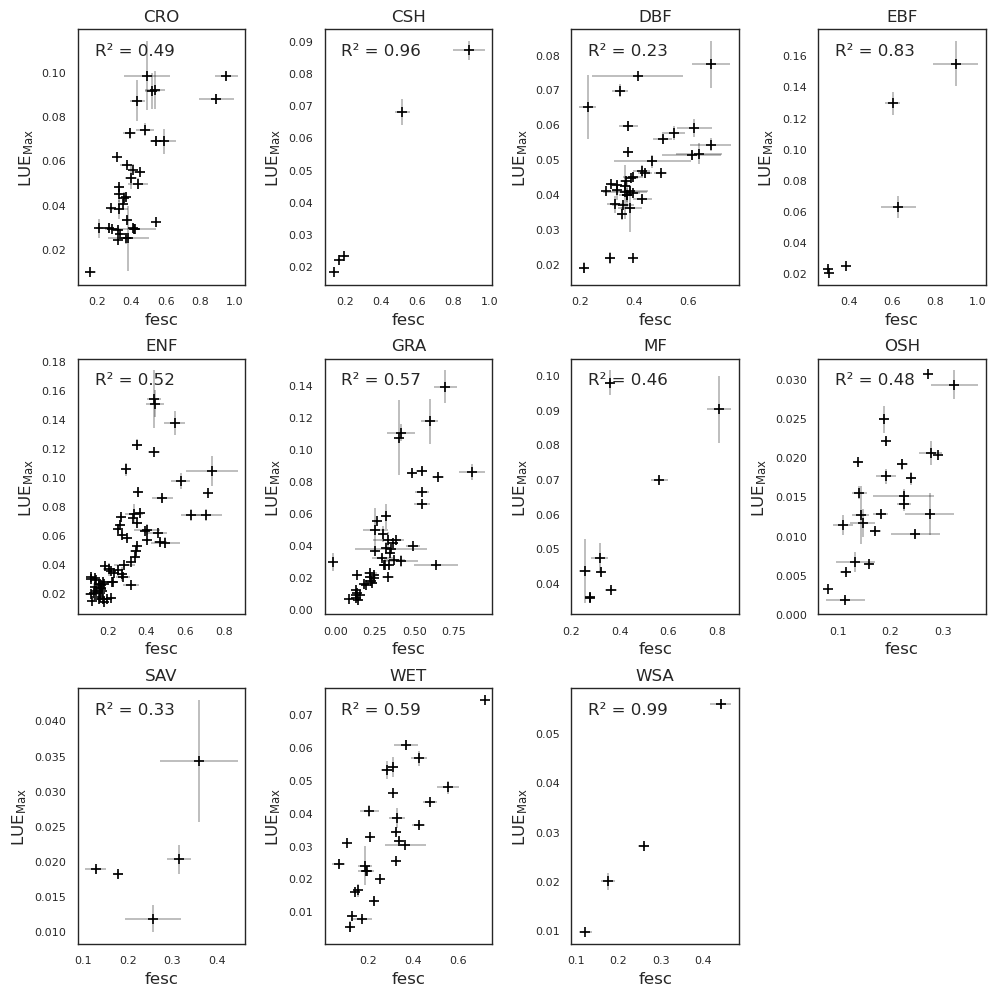

In [13]:
types = df["type"].unique()
types = np.setdiff1d(types, ["SNO", "CVM"])

fig, axs = plt.subplots(3, 4, figsize=(10, 10))  # Reduced figure size to fit A4 paper
axs = axs.flatten()

for i, type in enumerate(types):
    x = "fesc"
    y = "lue"
    site_annual_max_type = site_annual_max_lue[site_annual_max_lue["type"] == type]
    site_annual_max_se_type = site_annual_max_lue_se[
        site_annual_max_lue_se["type"] == type
    ]
    df_to_plot = site_annual_max_type
    axs[i].scatter(
        df_to_plot[x], df_to_plot[y], color="black", marker="+", s=50
    )  # Added color, alpha, and edgecolor for better visualization
    axs[i].set_title(f"{type}", fontsize=12)  # Adjusted font size
    axs[i].set_xlabel(x, fontsize=12)  # Adjusted font size
    axs[i].set_ylabel("LUE$_{\mathrm{Max}}$", fontsize=12)

    axs[i].errorbar(
        df_to_plot[x],
        df_to_plot[y],
        xerr=site_annual_max_se_type[x],
        yerr=site_annual_max_se_type[y],
        fmt="none",
        color="black",
        alpha=0.3,
    )

    # Calculate R²
    model = LinearRegression().fit(df_to_plot[[x]], df_to_plot[[y]])
    r2 = model.score(df_to_plot[[x]], df_to_plot[[y]])
    axs[i].text(
        0.1, 0.9, f"R² = {r2:.2f}", transform=axs[i].transAxes, fontsize=12
    )  # Add R² to the plot
    axs[i].tick_params(axis="both", labelsize=8)  # Adjusted font size

# Remove the extra subplots
for j in range(len(types), len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.savefig(
    "../outputs/figures/within_pft_fesc_lue.png", dpi=300, bbox_inches="tight"
)  # Adjusted file name and dpi

In [14]:
import pandas as pd
from sklearn.linear_model import LinearRegression

variables = ["fesc"]  # Variables to loop over
y = "lue"
site_r2 = {var: [] for var in variables}  # Initialize a dictionary to store R² values
site_types = []  # Initialize a list to store the types

for name in names:
    tmp_df = df[df["name"] == name]
    site_types.append(tmp_df["type"].iloc[0])  # Append the type of the site
    for x in variables:
        model = LinearRegression().fit(tmp_df[[x]], tmp_df[[y]])
        r2 = model.score(tmp_df[[x]], tmp_df[[y]])
        site_r2[x].append(r2)  # Append R² to the corresponding list in the dictionary

# Convert the dictionary to a pandas DataFrame
r2_df = pd.DataFrame(site_r2, index=names)
r2_df["type"] = site_types  # Add the types as a new column

/tmp/ipykernel_1609287/2495593204.py:15: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:white'` for the same effect.

  box_plot = sns.boxplot(


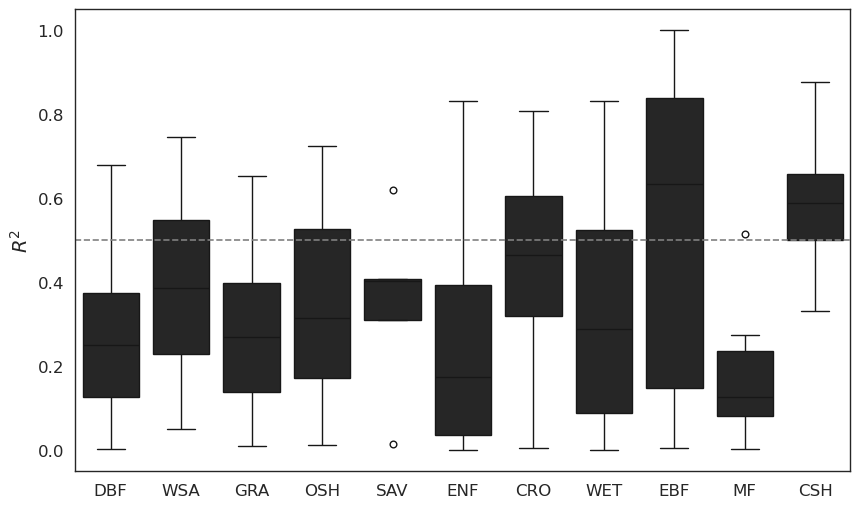

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

name = names[1]
tmp_df = df[df["name"] == name]
x = "lue"
y = "apar"
# Melt the DataFrame to have a long format
r2_df_melted = r2_df.melt(id_vars="type", var_name="variable", value_name="r2")

# Remove 'SNO' and 'CVM' types
r2_df_melted = r2_df_melted[~r2_df_melted["type"].isin(["SNO", "CVM"])]

plt.figure(figsize=(10, 6))
box_plot = sns.boxplot(
    x="type", y="r2", hue="variable", data=r2_df_melted, color="white"
)
# plt.title("R² for different variables by type")

# Change legend labels
new_labels = [f"{var} vs LUE" for var in r2_df.columns if var != "type"]
for t, l in zip(box_plot.legend_.texts, new_labels):
    t.set_text(l)
# Add horizontal line
plt.axhline(y=0.5, color="red", linestyle="--", c="gray")

# Remove legend title
box_plot.legend_.set_title(None)
box_plot.legend_.remove()
box_plot.set_xlabel("")
box_plot.set_ylabel(r"$R^2$", fontsize=14)
box_plot.tick_params(axis="x", labelsize=12)
box_plot.tick_params(axis="y", labelsize=12)
plt.savefig(
    "../outputs/figures/within_sites_r2_fesc_lue.png", dpi=300, bbox_inches="tight"
)